Problem 1: Separation of variables method

The heat equation is:

$$\frac{\partial u(x,t)}{\partial t} - \alpha \frac{\partial^2 u(x,t)}{\partial x^2} = 0$$

Considering a rod of length L with Neumann boundary conditions gives

$$\frac{\partial u(0,t)}{\partial x} = \frac{\partial u(L,t)}{\partial x} = 0$$

For separating variables, let $u(x,t) = P(x)Q(t)$ so the heat equation is now

$$P(x)\frac{\partial Q(t)}{\partial t} = \alpha Q(t)\frac{\partial^2 P(x)}{\partial x^2}$$

divding each side by the original function $u$ shows that
$$\frac{\dot Q}{Q} = \alpha \frac{P''}{P}$$

The fact that this is true means that each side of the equation must be equal to a constant since functions of different variables are set equal to each other (i.e. they technically have different units)

Because both sides are equl to some constant, they can now be dealt with individually:

$$\frac{dQ}{dt}/Q = C \Rightarrow Q(t) = Q_0 e^{Ct}$$

and 

$$\alpha \frac{\frac{d^2P}{dx^2}}{P} = C \Rightarrow P(x) = Ae^{x\sqrt{C/\alpha}} + Be^{-x\sqrt{C/\alpha}}$$

Given the boundary conditions and $u(x,t) = P(x)Q(t)$ we know 

$$Q(t)P'(0) = Q(t) P'(L) = 0$$
$\therefore P'(0) = P'(L) = 0 = A\sqrt{C/\alpha} - B\sqrt{C/\alpha} \Rightarrow A = B$


For $P'(L) = 0$, 

$$A\sqrt{C/\alpha}e^{L\sqrt{C/\alpha}} - A\sqrt{C/\alpha}e^{-L\sqrt{C/\alpha}} = 0$$

So $C$ is negative (C=0 is meaningless for our purposes) yielding imaginary numbers in the exponentials which gives ocsillating solutions like so:

$$Ake^{i kL} - Ake^{-i kL} = 0$$ where $k = \sqrt{C/\alpha}$
$$2i Ak\sin(kL) = 0$$
$$kL = n\pi$$
$$C = -\alpha (n\pi / L)^2 $$

so the full solution is 

$$u(x,t) = \sum_{n=-\inf}^{-\inf}c_n e^{Ct}\cos (n\pi x/L) $$ with $c_n$ as an arbitrary constant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import animation
from IPython.display import HTML
import scipy.sparse as sparse



Problem 2: Solving with finite difference method 

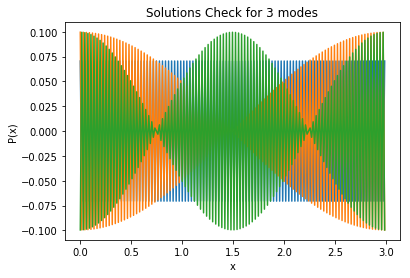

In [2]:
class HProb(object):
    
    def __init__(self, N=201,L=3,**kwargs):
        self.kwargs = kwargs
        self.N = N
        self.L = L
        self.dx = L/np.float(N)
        self.x = np.arange(N) * self.dx
        self.a = None
        self.evals = None
        self.evecs = None
    
    def alpha(self):
        return 1. * self.dx**( -2. ) * np.ones(self.N)
    
    def Amat(self):
        alpha = np.diag(self.alpha())
        diags = sparse.diags([1. , -2. , 1.],offsets = [-1, 0 , 1],shape = (self.N , self.N)).toarray()
        diags[0][1] = 2.
        diags[self.N - 1][self.N - 2] = 2.
        self._Amat = alpha.dot(diags)
        return self._Amat
    
    def eigsys(self):
    #if self.evals is None and self.evecs is None:
        vals, vecs = np.linalg.eig(self.Amat())
        self.evals = vals[np.argsort(vals)]
        self.evecs = vecs[:,np.argsort(vals)]
        return self
    #else:
            #return self
    
    def eigc(self, array):
        U, w, VT = np.linalg.svd(self.eigsys().evecs)
        inds = np.where(w>(1.e-15))[0]
        invw = np.zeros(len(w))
        invw = 1./ (w[inds])
        inv = VT.T.dot(np.diag(invw)).dot(U.T)
        return inv.dot(array)
    
    def get_wts(self, c):
        self.c = c
        
    def tplot(self, numframe = 80, T = 2. , ylim = [-1,1]):
        fig, ax = plt.subplots()
        x = self.x
        evals = self.eigsys().evals
        evecs = self.evecs 
        c = self.c
        ax.set_xlim([0,self.L])
        ax.set_ylim(ylim)
        line, = ax.plot([],[],lw= 2)
    
        def frame():
            line.set_data([],[])
            return line,
        def h(i):
            t = T * (np.float(h)/np.float(numframe))
            const = c * np.exp(evals * t)
            ufunc = evecs.dot(const).flatten()
            line.set_data(x, ufunc)
            return line,
        plt.close(fig)
        return animation.FuncAnimation(fig, h, init_func = frame , frames = numframe, interval = 33,blit = True)


Hstate = HProb().eigsys()
plt.figure()
for i in range(3):
    plt.plot(Hstate.x,Hstate.evecs[:,i])
plt.title('Solutions Check for 3 modes')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()


The graph agrees with the analytical solutions as it displays sinusoidal envelopes for various modes.

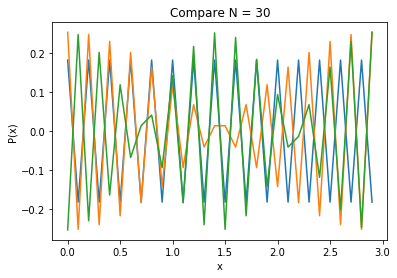

In [3]:
diffstate = HProb(N = 30).eigsys()
plt.figure()
plt.title('Compare N = 30')
for i in range(3):
    plt.plot(diffstate.x,diffstate.evecs[:,i])
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()


This is a lot less accurate as N is too low.

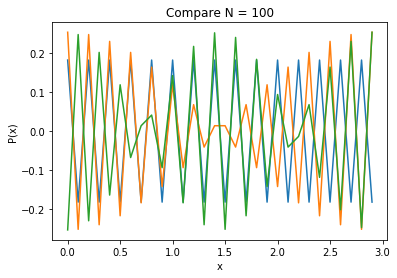

In [4]:
diffstate2 = HProb(N = 100).eigsys()
plt.figure()
plt.title('Compare N = 100')
for i in range(3):
    plt.plot(diffstate.x,diffstate.evecs[:,i])
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

This is a somewhat better since N is larger

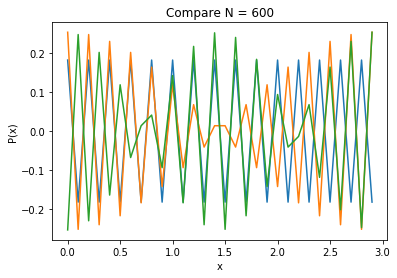

In [5]:
diffstate3 = HProb(N = 300).eigsys()
plt.figure()
plt.title('Compare N = 600')
for i in range(3):
    plt.plot(diffstate.x,diffstate.evecs[:,i])
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

The same follows here though I'm not sure why these plots dont look like the original

In [ ]:
HP = HProb(N=600)
init_cond = mlab.normpdf( HP.x , HP.L / 2. , .5 )
HP.get_wts(HP.eigc(init_cond))
y = HP.tplot(numframe = 200, T = 2.)
HTML(y.to_html5_video())

Problem 3: altering $\alpha$ to be $\alpha (x)$ and putting a "barrier" of low diffusivity somewhere

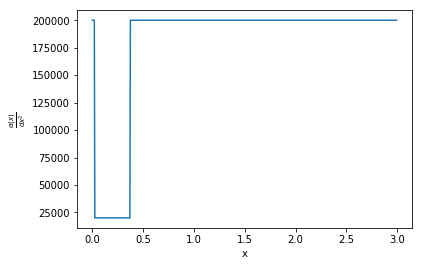

In [6]:
class BHP(HProb):
    def alpha(self):
        d = 5
        b = .5
        val = np.arange(5,75)
        al = d * np.ones(self.N)
        al[val] = b
        return 1. * self.dx**(-2)*al
barrier = BHP(N = 600)

plt.figure()
plt.plot(barrier.x,barrier.alpha())
plt.xlabel('x')
plt.ylabel(r'$\frac{\alpha (x)}{dx^2}$')
plt.show()


    

In [ ]:
init_cond = mlab.normpdf( barrier.x , barrier.L / 2. , .5 )
barrier.get_wts(barrier.eigc(init_cond))
y = barrier.tplot(numframe = 200, T = 2.)
HTML(y.to_html5_video())

The heat source diffuses further to the right since the barrier is set up on the left